In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [16]:
IMG_FOLDER_PATH = r'C:\Users\mikeg\dev\MachineLearning\music-gesture-steering\image_data'

batch_size = 32
IMG_SIZE = (250,250)

In [17]:
train_ds = image_dataset_from_directory(
    IMG_FOLDER_PATH,
    validation_split = 0.2,
    subset = "training",
    seed = 1,
    image_size = IMG_SIZE,
    batch_size = batch_size
)

Found 1500 files belonging to 5 classes.
Using 1200 files for training.


In [18]:
val_ds = image_dataset_from_directory(
    IMG_FOLDER_PATH,
    validation_split = 0.2,
    subset = "validation",
    seed = 1,
    image_size = IMG_SIZE,
    batch_size = batch_size
)

Found 1500 files belonging to 5 classes.
Using 300 files for validation.


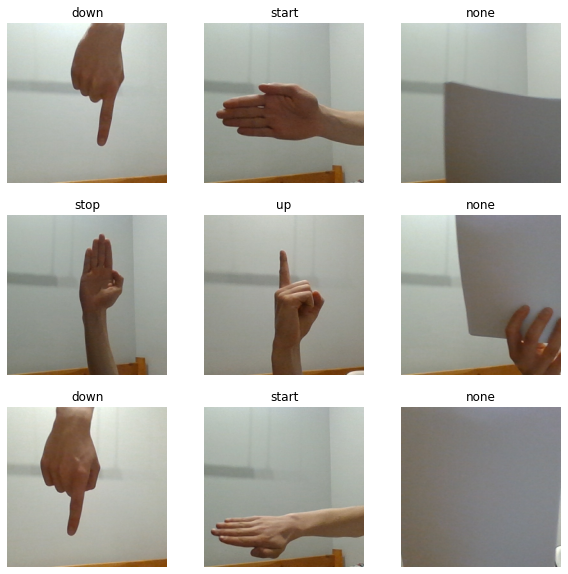

In [19]:
class_names = train_ds.class_names

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [20]:
print(class_names)

['down', 'none', 'start', 'stop', 'up']


In [21]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 8
Number of test batches: 2


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

In [23]:
x_model = Xception(input_shape=IMG_SIZE + (3,), include_top=False)
x_model.trainable = False

In [24]:
inputs = tf.keras.Input(shape=(250,250,3))
x = preprocess_input(inputs)
x = x_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x)
model = Model(inputs, outputs)

In [25]:
model.compile(optimizer=Adam(lr=0.0001),
                loss=SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [26]:
model.fit(train_ds,
            epochs=10,
            validation_data=val_ds)

Epoch 1/10
38/38 [==============================] - 39s 950ms/step - loss: 1.6945 - accuracy: 0.1678 - val_loss: 1.3664 - val_accuracy: 0.5847
Epoch 2/10
38/38 [==============================] - 36s 935ms/step - loss: 1.3039 - accuracy: 0.5778 - val_loss: 1.0574 - val_accuracy: 0.9576
Epoch 3/10
38/38 [==============================] - 36s 940ms/step - loss: 1.0247 - accuracy: 0.8843 - val_loss: 0.8061 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 37s 943ms/step - loss: 0.8061 - accuracy: 0.9543 - val_loss: 0.6219 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 37s 948ms/step - loss: 0.6233 - accuracy: 0.9915 - val_loss: 0.4990 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 37s 951ms/step - loss: 0.5087 - accuracy: 0.9904 - val_loss: 0.4062 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 37s 961ms/step - loss: 0.4170 - accuracy: 0.9968 - val_loss: 0.3366 - val_accuracy: 1.0000

In [27]:
loss, accuracy = model.evaluate(test_ds)

2/2 [==============================] - 3s 766ms/step - loss: 0.2289 - accuracy: 1.0000


In [28]:
model.save("models/music-gesture-model.h5")

In [6]:
import tensorflowjs as tfjs
model = tf.keras.models.load_model('models/music-gesture-model.h5')
tfjs.converters.save_keras_model(model, 'models/js-model')